## LASSO REGRESSION : SQL DATABASE (MSFT & AAPL)

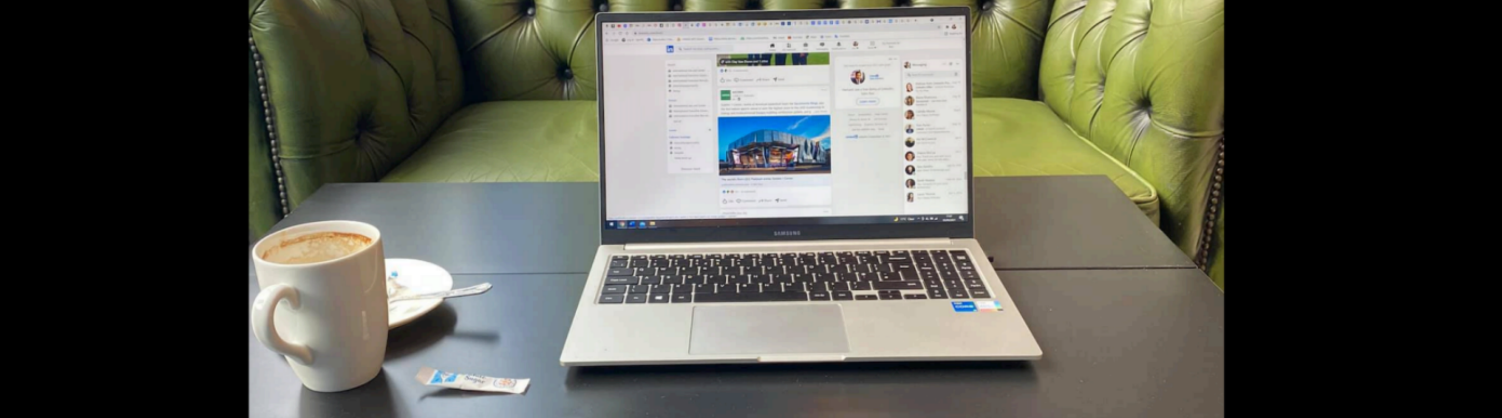

### Hemant Thapa

#### 1. Loading Dataset

In [1]:
import os
import sqlite3
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tabulate import tabulate

#### 2. Connecing Data Base

In [2]:
#connecting database
def connect_database(database_name):
    conn = sqlite3.connect(database_name)
    cursor = conn.cursor()
    return conn, cursor

In [3]:
database = "stocks_master.db"
conn, cursor = connect_database(database)

In [4]:
if conn and cursor:
    #finding tables in the database
    def find_tables(conn):
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        return [table[0] for table in tables]
        
    tables_in_database = find_tables(conn)
    print(tables_in_database)
    #closing the connection
    conn.close()
else:
    print("Exiting due to connection error.")

['stock_prices_aapl', 'stock_prices_msft', 'stock_prices_goog', 'stock_prices_googl', 'stock_prices_amzn', 'stock_prices_nvda', 'stock_prices_meta', 'stock_prices_tsla', 'stock_prices_lly', 'stock_prices_v', 'stock_prices_avgo', 'stock_prices_jpm', 'stock_prices_tsm', 'stock_prices_nvo', 'stock_prices_unh', 'stock_prices_wmt', 'stock_prices_xom', 'stock_prices_ma', 'stock_prices_jnj', 'stock_prices_pg', 'stock_prices_hd', 'stock_prices_cost', 'stock_prices_mrk', 'stock_prices_orcl', 'stock_prices_abbv', 'stock_prices_asml', 'stock_prices_cvx', 'stock_prices_adbe', 'stock_prices_tm', 'stock_prices_crm', 'stock_prices_bac', 'stock_prices_amd', 'stock_prices_pep', 'stock_prices_acn', 'stock_prices_nvs', 'stock_prices_nflx', 'stock_prices_azn', 'stock_prices_mcd', 'stock_prices_tmo', 'stock_prices_shel', 'stock_prices_csco', 'stock_prices_intc', 'stock_prices_lin', 'stock_prices_abt', 'stock_prices_pdd', 'stock_prices_tmus', 'stock_prices_sap']


In [5]:
tables_in_database[0]

'stock_prices_aapl'

#### 3. Feature Selection  

In [6]:
master_database_name = "stocks_master.db"
master_conn = sqlite3.connect(master_database_name)

In [7]:
if master_conn:
    #tables to query
    tables_to_query = ['stock_prices_aapl', 'stock_prices_msft']
    #iterate over the tables in the master database
    for table_name in tables_to_query:
        #new cursor for the query
        query_cursor = master_conn.cursor()
        query = f"SELECT Date, Open, High, Low, Close, 'Adj Close' AS 'Adjusted Close', Volume FROM {table_name} ORDER BY Date DESC LIMIT 10"
        query_cursor.execute(query)
        data = query_cursor.fetchall()
        #extracting columns from the data
        result_list = [list(row) for row in data]
        #tabular format
        print(f"\nTop five rows of {table_name}:\n")
        print(tabulate(result_list, headers=["Date", "Open", "High", "Low", "Close", "Adjusted Close", "Volume"], tablefmt="grid"))
else:
    print("Master connection is closed.")


Top five rows of stock_prices_aapl:

+---------------------+--------+--------+--------+---------+------------------+----------+
| Date                |   Open |   High |    Low |   Close | Adjusted Close   |   Volume |
+=====================+========+========+========+=========+==================+==========+
| 2024-01-12 00:00:00 | 186.06 | 186.74 | 185.19 |  185.92 | Adj Close        | 40444700 |
+---------------------+--------+--------+--------+---------+------------------+----------+
| 2024-01-11 00:00:00 | 186.54 | 187.05 | 183.62 |  185.59 | Adj Close        | 49128400 |
+---------------------+--------+--------+--------+---------+------------------+----------+
| 2024-01-10 00:00:00 | 184.35 | 186.4  | 183.92 |  186.19 | Adj Close        | 46792900 |
+---------------------+--------+--------+--------+---------+------------------+----------+
| 2024-01-09 00:00:00 | 183.92 | 185.15 | 182.73 |  185.14 | Adj Close        | 42841800 |
+---------------------+--------+--------+--------+--

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [9]:
def fetch_closing_prices_and_dates(table_name, symbol):
    query_cursor = master_conn.cursor()
    query = f"SELECT Date, Open, High, Low, Close, 'Adj Close' AS 'Adjusted Close', Volume FROM {table_name} ORDER BY Date DESC LIMIT 900"
    query_cursor.execute(query)
    data = query_cursor.fetchall()
    closing_prices = [float(row[1]) for row in data]
    dates = [row[0] for row in data]
    return dates, closing_prices

In [10]:
x_table_name = 'stock_prices_msft'
y_table_name = 'stock_prices_aapl'

In [11]:
x_dates, x_closing_prices = fetch_closing_prices_and_dates(x_table_name, 'MSFT')
y_dates, y_closing_prices = fetch_closing_prices_and_dates(y_table_name, 'AAPL')

In [12]:
common_dates = set(x_dates) & set(y_dates)

In [13]:
X_closing_prices = [x_closing_prices[x_dates.index(date)] for date in common_dates]
y_closing_prices = [y_closing_prices[y_dates.index(date)] for date in common_dates]

In [14]:
print(f"Length of X: {len(X_closing_prices)}")
print(f"Length of Y: {len(y_closing_prices)}")

Length of X: 900
Length of Y: 900


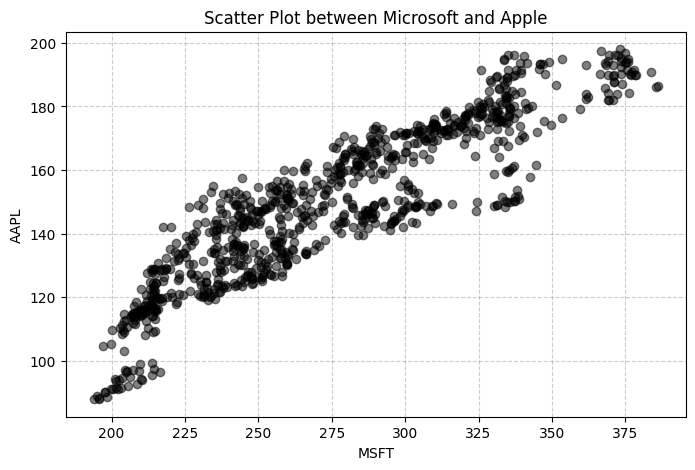

In [15]:
plt.figure(figsize=(8,5))
plt.scatter(X_closing_prices, y_closing_prices, color='black', alpha=0.5)
plt.title("Scatter Plot between Microsoft and Apple")
plt.xlabel("MSFT")
plt.ylabel("AAPL")
plt.grid(True, ls='--', color='black', alpha=0.2)
plt.show()

In [16]:
X = np.array(X_closing_prices).reshape(-1, 1)
y = np.array(y_closing_prices)

#### 4. Feature Scaling 

In [17]:
#Z-scores 
X = (X - X.mean()) / X.std()

In [18]:
#splitting data into train and test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
#polynomial regression
degree = 4
poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train)
X_poly_test = poly_features.transform(X_test)

#### 5. Model Selection

In [20]:
from sklearn.linear_model import Lasso

In [21]:
lasso_model = Lasso(alpha=0.001, max_iter=50000)  
lasso_model.fit(X_poly_train, y_train)

Lasso(alpha=0.001, max_iter=50000)

In [22]:
line_test = np.linspace(min(X_test), max(X_test), 100).reshape(-1, 1)

In [23]:
line_poly = poly_features.transform(line_test)

In [24]:
y_pred = lasso_model.predict(line_poly)

In [25]:
y_pred[:5]

array([ 90.50706124,  93.72749272,  96.79503351,  99.71579451,
       102.49577065])

#### 6. Best Fit Line (Predictive Analaysis)

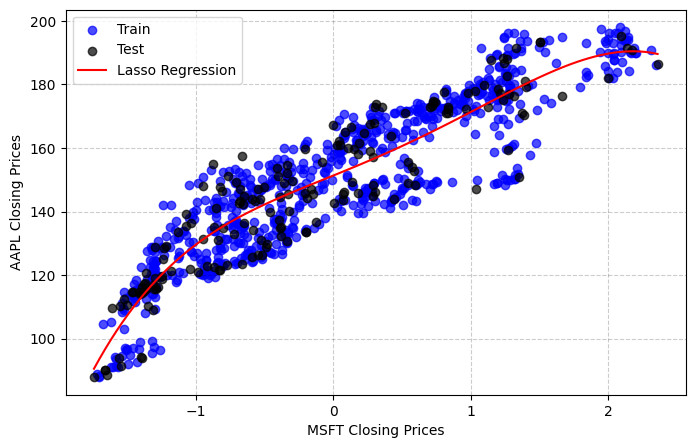

In [26]:
plt.figure(figsize=(8,5))
plt.scatter(X_train, y_train, color='blue', alpha=0.7, label='Train')
plt.scatter(X_test, y_test, color='black', alpha=0.7, label='Test')
plt.plot(line_test, y_pred, color='red', label=f'Lasso Regression')
plt.xlabel("MSFT Closing Prices")
plt.ylabel("AAPL Closing Prices")
plt.grid(True, ls='--', color='black', alpha=0.2)
plt.legend()
plt.show()

#### 7. Model Evaluation 

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [28]:
#R-squared for the model
r2 = r2_score(y_test, lasso_model.predict(X_poly_test))
#mean squared error (MSE) for the model
mse = mean_squared_error(y_test, lasso_model.predict(X_poly_test))
#RMSE for the model
rmse = np.sqrt(mean_squared_error(y_test, lasso_model.predict(X_poly_test)))
#MAE for the model
mae = mean_absolute_error(y_test, lasso_model.predict(X_poly_test))
print(f'R-squared: {r2}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

R-squared: 0.8610181246830063
Mean Squared Error (MSE): 87.27093431732187
Root Mean Squared Error (RMSE): 9.341891367240462
Mean Absolute Error (MAE): 7.761138159113475


In [29]:
#residuals
residuals = y_test - lasso_model.predict(X_poly_test)

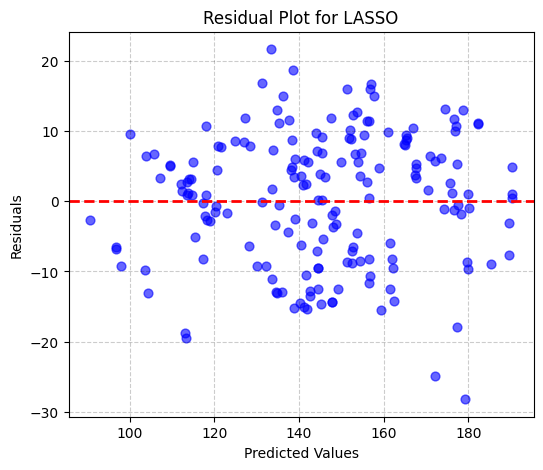

In [30]:
#residuals against predicted values
plt.figure(figsize=(6,5))
plt.scatter(lasso_model.predict(X_poly_test), residuals, color='blue', marker='o', s=40, alpha=0.6)
plt.title('Residual Plot for LASSO')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, ls='--', color='black', alpha=0.2)
plt.show()

In [31]:
from scipy.stats import probplot

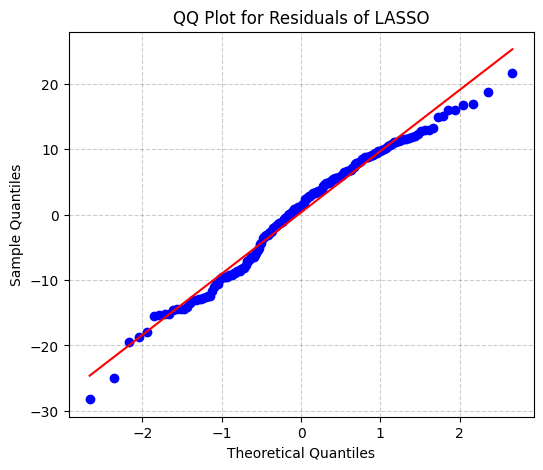

In [32]:
#QQ plot
plt.figure(figsize=(6,5))
probplot(residuals, plot=plt)
plt.title('QQ Plot for Residuals of LASSO')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True, ls='--', color='black', alpha=0.2)
plt.show()

#### References: 

1. Linear Regression in SQL: Is it Possible? [Medium](https://medium.com/swlh/linear-regression-in-sql-is-it-possible-b9cc787d622f)
2. Linear Regression in SQL [Towards Data Science](https://towardsdatascience.com/linear-regression-in-sql-62eaf4861290)
